# Tutorial: Fitting a DA Spectrum

For this demonstration, we use a sample spectrum from the Sloan Digital Sky Survey (SDSS) named SDSS J082600.58+282346.2. 

Tremblay et al. (2019) assigned this star an effective temperature of $13917$ Kelvin and a surface gravity of $8.06$ log[cm/s^2] using their latest atmospheric models and this SDSS spectrum. In this notebook we'll demonstrate how you can use `wdtools` to infer these parameters from any white dwarf spectrum. 

In [1]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
h_alpha = 6564.61
speed_light = 299792458 #m/s


import sys
sys.path.append('../../') # Your path should contain the parent GitHub repository

import wdtools

In [2]:
with fits.open('sample_spectrum.fits') as f:
    flux = f[1].data['flux']
    wl = 10**f[1].data['loglam']
    ivar = f[1].data['ivar']

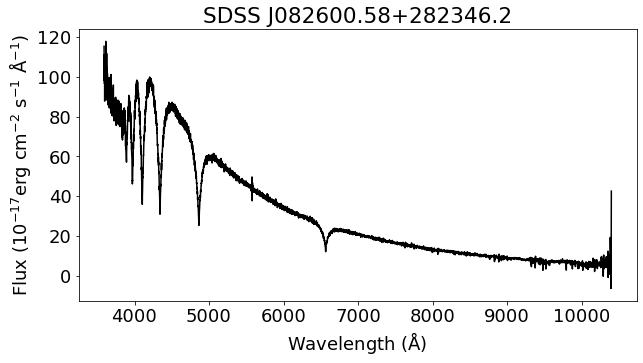

In [3]:
plt.figure(figsize = (10,5))
plt.plot(wl, flux, 'k')
plt.xlabel('Wavelength ($\mathrm{\AA}$)');
plt.ylabel('Flux ($\mathrm{10^{-17} erg\ cm^{-2}\ s^{-1}\ \AA^{-1}}$)')
plt.title('SDSS J082600.58+282346.2');

## Generative Fitting Pipeline

We normalize the hydrogen Balmer lines and fit atmospheric models from Koester (2010) to this spectrum using our MCMC algorithm.

In [4]:
gfp = wdtools.GFP(resolution = 2, specclass = 'DA')

We pass the instrumental resolution in Angstroms when we initialize `GFP`. The theoretical models are convolved with a Gaussian kernel with this resolution prior to each fitting step. We also select the `'DA'` spectral class to fit pure-hydrogen models. At this time, these are the only models available. In future we hope to include helium (DB) models when those models become publicly available. 

fitting continuum...


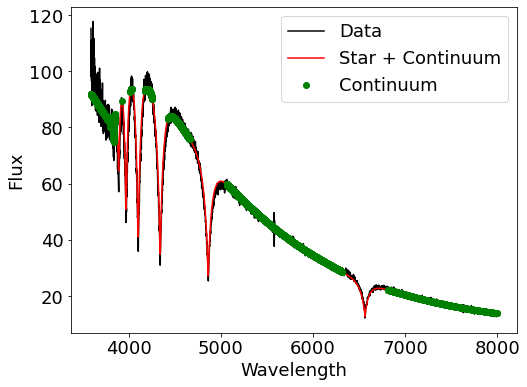

initial guess: T = 11349, logg = 8.63
fitting radial velocity...
Radial Velocity = 41 km/s
fitting cool solution...
cool solution: T = 13478 K, logg = 8.2 dex, chi2 = 1270.4
fitting warm solution...
warm solution: T = 13481 K, logg = 8.2 dex, chi2 = 1270.4
initializing at cool solution, T = 13478 K, logg = 8.2 dex
burning in chains...


100%|██████████| 50/50 [01:17<00:00,  1.56s/it]


sampling posterior...


100%|██████████| 50/50 [01:15<00:00,  1.51s/it]


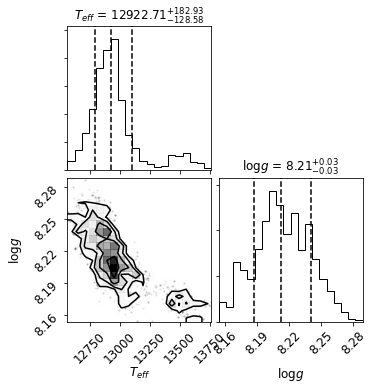

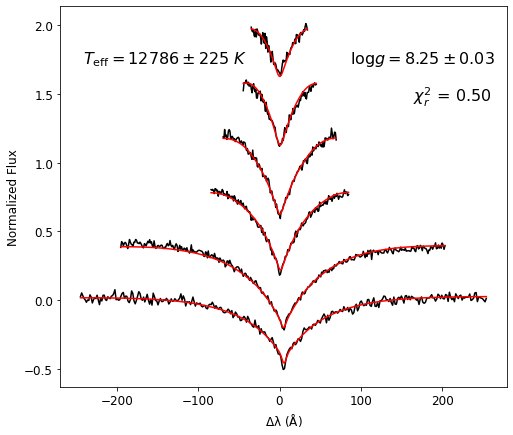

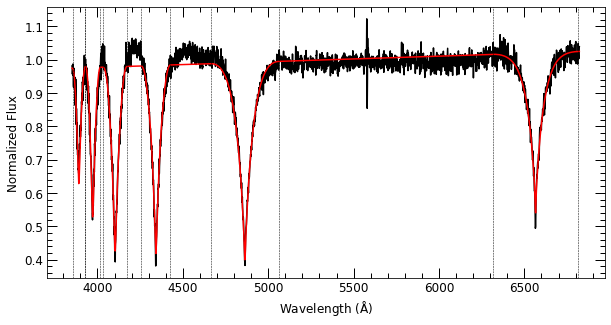

In [5]:
labels, e_labels, redchi = gfp.fit_spectrum(wl, flux, ivar,
                                mcmc = True, nwalkers = 50, burn = 50, ndraws = 50,
                                plot_init = True, make_plot = True, plot_corner = True, savename = 'example',
                                verbose = True)

In [6]:
print('Teff = %i ± %i Kelvin' % (labels[0], e_labels[0]))
print('logg = %.2f ± %.2f log[cm/s^2]' % (labels[1], e_labels[1]))
print('RV = %.1f ± %.1f km/s' % (labels[2], e_labels[2]))
print('reduced chi^2 = %.2f' % (redchi))

Teff = 12786 ± 225 Kelvin
logg = 8.25 ± 0.03 log[cm/s^2]
RV = 42.0 ± 0.0 km/s
reduced chi^2 = 0.50


All parameters passed to `gfp.fit_spectrum` other than the normalized wavelength and flux are optional. If no inverse variance `ivar` array is passed, then the software will estimate the flux uncertainty using the beta-sigma method. This will make the $\chi^2$ likelihood inexact, so treat the parameter posterior distributions with caution.

We initialize the sampling at a high-probability region of parameter space by finding parameters that minimize the $\chi^2$ using a Nelder-Mead solver. We fit once with a 'cold' prior (T < 15000 K), and once with a 'hot' prior (T > 15000 K), and select the one with the lowest $\chi^2$ as the initialization point. 

The MCMC hyperparameter selection involves a trade-off between accuracy and speed. Unless you have a particular need for more samples or quicker sampling, you can leave them at the default settings, which should enable you to fit a single spectrum in under a minute on a regular laptop computer. We recommend keeping `burn` greater than 100 steps at least, so that walkers can spread out from the high-probability starting point and explore the likelehood. Otherwise, the errors on fitted parameters can be grossly underestimated. You can also pass the `mcmc = False` keyword to `fit_spectrum` to skip the MCMC sampling and simply return the optimized solution:

fitting continuum...
initial guess: T = 11349, logg = 8.63
fitting radial velocity...
Radial Velocity = 41 km/s
fitting cool solution...
cool solution: T = 13478 K, logg = 8.2 dex, chi2 = 1270.4
fitting warm solution...
warm solution: T = 13481 K, logg = 8.2 dex, chi2 = 1270.4


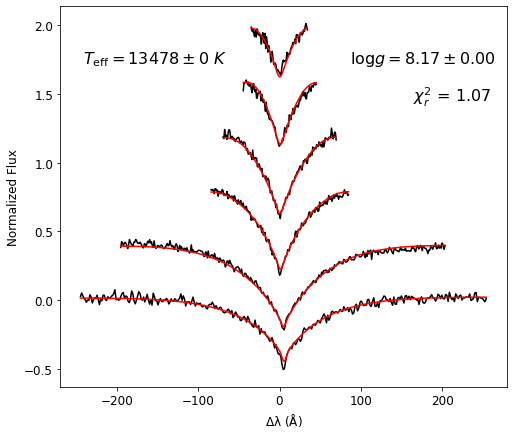

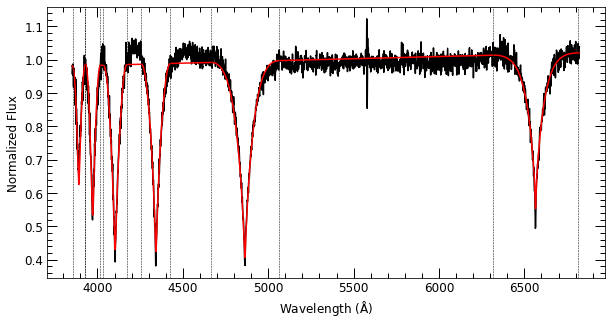

In [7]:
labels, e_labels, redchi = gfp.fit_spectrum(wl, flux, ivar,
                                mcmc = False, make_plot = True, verbose = True)

In [8]:
print('Teff = %i ± %i Kelvin' % (labels[0], e_labels[0]))
print('logg = %.2f ± %.2f log[cm/s^2]' % (labels[1], e_labels[1]))
print('RV = %.1f ± %.1f km/s' % (labels[2], e_labels[2]))
print('reduced chi^2 = %.2f' % (redchi))

Teff = 13478 ± 0 Kelvin
logg = 8.17 ± 0.00 log[cm/s^2]
RV = 42.0 ± 0.0 km/s
reduced chi^2 = 1.07


## Parametric Random Forest

Rather than fitting ab-inito models directly to observed spectra, the parametric random forest in `wdtools` forms a regression relation between the hydrogen Balmer lines on the spectrum and stellar labels derived by previous studies. Whilst this method is less interpretable than the full statistical approach described above, it is much faster and therefore suitable for statistical analyses on larger samples. Additionally, fitting an ab-initio model directly requires some care regarding multi-modal posteriors, photometric temperature priors, and so on. 

We train our model with a pre-existing catalog of stars that have been carefully fitted for their stellar labels (keeping all the confounding effects in mind) by Tremblay et al. (2019). For more details, refer to our paper or software documentation.

In [9]:
lp = wdtools.LineProfiles(lines = ['alpha', 'beta', 'gamma', 'delta'])

The trianing SDSS data only permitted high-quality line profile fits to the first 4 Balmer lines, so you can only pass some subset of those for this method. The first time you call `LineProfiles` on your machine, it will perform a self-initialization to train its regression model for the provided combination of lines and save it in the `models/` folder. This should only take a few seconds and will create a ~60 MB pickled random forest model that will be used every time you subsequently call `LineProfiles`. 

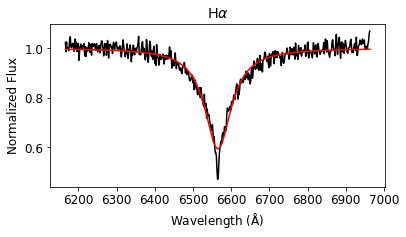

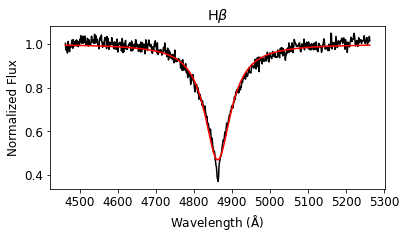

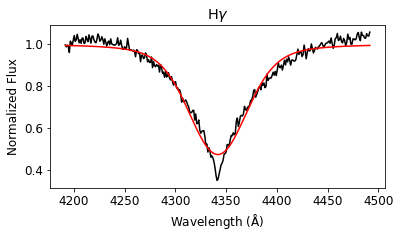

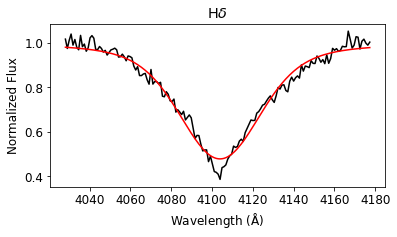

In [10]:
results = lp.labels_from_spectrum(wl, flux, make_plot = True)

In [11]:
print('Teff = %i ± %i Kelvin' % (results[0], results[1]))
print('logg = %.2f ± %.2f log[cm/s^2]' % (results[2], results[3]))

Teff = 13912 ± 295 Kelvin
logg = 8.10 ± 0.06 log[cm/s^2]


The `labels_from_spectrum` method fits all selected Balmer lines with a Voigt profile to compute their FWHM and height, and then runs the fitted parameters through the ensemble of random forest regression models to produce stellar label estimates with uncertainties. 

Both our methods produce self-consistent stellar labels that are also consistent with the prior result from Tremblay et al. (2019).

For any more details, questions, or comments please don't hesistate to contact the authors via email. You can also [raise an issue](https://github.com/vedantchandra/wdtools/issues) on GitHub for specific software bugs or feature requests. We hope you enjoy using wdtools!